In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin_cached_model as lcm
import pymc3 as pm
import scipy.io
import scipy as sp

In [3]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    return Q/N,B

In [4]:
oxy_data37=scipy.io.loadmat('results/fMRI/OXY37_MRI_1_ts.mat')

mean:  -6.40646955775e-14
var:  43.9215908216
N:  736
relaxation time: 7.78708114601
1.00260386676


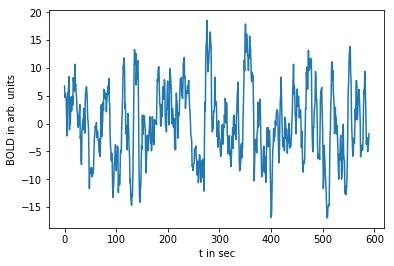

In [11]:
mpfc_r_ts=oxy_data37['mpfc_r_ts']
mpfc=np.mean(mpfc_r_ts,axis=0)
print("mean: ",mpfc.mean())
print("var: ",mpfc.std()**2)
N=len(mpfc)
print("N: ",N)
mpfc_A,mpfc_B = OUanalytic(mpfc)
print("relaxation time:",-0.802/np.log(mpfc_B))
mpfc_norm=mpfc/np.sqrt(mpfc_A)
print(mpfc_norm.std())
t = np.arange(N)*0.802 # tR = 0.802 sec
plt.plot(t,mpfc)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

mean:  -8.15965652533e-14
var:  36.788213768
N:  736
relaxation time: 8.86543894463
1.00603547113


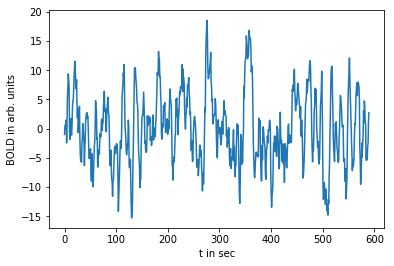

In [10]:
pcc_r_ts=oxy_data37['pcc_r_ts']
pcc=np.mean(pcc_r_ts,axis=0)
print("mean: ",pcc.mean())
print("var: ",pcc.std()**2)
N=len(pcc)
print("N: ",N)
pcc_A,pcc_B = OUanalytic(pcc)
print("relaxation time:",-0.802/np.log(pcc_B))
pcc_norm=pcc/np.sqrt(pcc_A)
print(pcc_norm.std())
plt.plot(t,pcc)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

mean:  -1.73831963317e-13
var:  13.3465095649
N:  736
relaxation time: 5.67436670013
1.00363933686


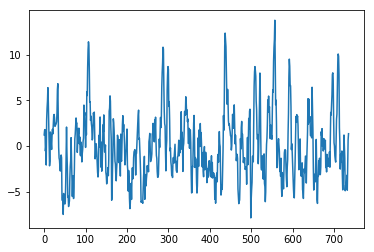

In [12]:
rlp_r_ts=oxy_data37['rlp_r_ts']
rlp=np.mean(rlp_r_ts,axis=0)
plt.plot(rlp)
print("mean: ",rlp.mean())
print("var: ",rlp.std()**2)
N=len(rlp)
print("N: ",N)
rlp_A,rlp_B = OUanalytic(rlp)
print("relaxation time:",-0.802/np.log(rlp_B))
rlp_norm=rlp/np.sqrt(rlp_A)
print(rlp_norm.std())

mean:  -1.19749620847e-13
var:  73.2901308929
N:  736
relaxation time: 9.45267995758
1.00614250393


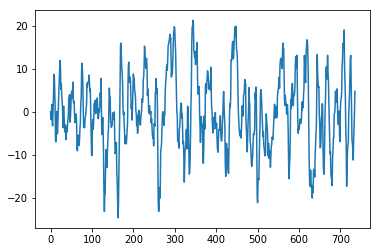

In [13]:
llp_r_ts=oxy_data37['llp_r_ts']
llp=np.mean(llp_r_ts,axis=0)
plt.plot(llp)
print("mean: ",llp.mean())
print("var: ",llp.std()**2)
N=len(llp)
print("N: ",N)
llp_A,llp_B = OUanalytic(llp)
print("relaxation time:",-0.802/np.log(llp_B))
llp_norm=llp/np.sqrt(llp_A)
print(llp_norm.std())

In [28]:
def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A, x1_B = OUanalytic(x1)
    x2_A, x2_B = OUanalytic(x2)
    return (x1_A - x2_A)/x2_A
print(OUcross(mpfc_norm,pcc_norm))
print(OUcross(mpfc_norm,rlp_norm))
print(OUcross(mpfc_norm,llp_norm))
print(OUcross(pcc_norm,rlp_norm))
print(OUcross(pcc_norm,llp_norm))
print(OUcross(rlp_norm,llp_norm))

11.2736044314
0.885471845355
3.66581801856
1.14251791253
8.35049631085
1.32708145158
